# Testing the Linear Model trained in TensorFlow 

In [1]:
from __future__ import print_function
from link_bot_notebooks import toy_problem_optimization_common as tpo
from math import acos
import numpy as np
import matplotlib.pyplot as plt
from link_bot_notebooks.linear_tf_model import LinearTFModel

In [2]:
args = {'checkpoint': "log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000", 'log': False, 'batch_size': 1024}
dataset = "../../../link_bot_teleop/data/random_50_steps.txt"
n_steps = 50
dt = 0.1
x = tpo.load_train(dataset, N=6, L=2, n_steps=n_steps, extract_func=tpo.link_pos_vel_extractor2(6))
model = LinearTFModel(args, N=6, M=2, L=2, n_steps=1, dt=dt)
model.load()

INFO:tensorflow:Restoring parameters from log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000
Restored ckpt log_data/init_A/December_10_23:11:39__0a0464776e/nn.ckpt-175000 at step 175000


In [3]:
goal = np.array([[0], [0], [1], [0], [2], [0]])
og = model.reduce(goal)

In [4]:
A, B, C, D = model.get_ABCD()

In [5]:
print(model)
example_s = np.array([0, 5, 0, 6, 0, 7])
print('example s:', example_s)
example_o = np.expand_dims(np.dot(A, example_s), axis=1)
print('example o:', example_o.T)
example_u = np.linalg.lstsq(C, (og - example_o - np.dot(B, example_o)), rcond=None)[0]
print('example u:', example_u.T)

A:
[[ 0.19133253 -0.44328988  0.04912092  0.00576457 -0.00919639 -0.08806095]
 [-0.2548282  -0.10180641 -0.02384943 -0.0447261  -0.09409841 -0.0404095 ]]
B:
[[-0.02886412  0.15023094]
 [-0.10997132  0.01284277]]
C:
[[  7.5052586 -26.444324 ]
 [-23.279642   -7.1835437]]
D:
[[ 3.1318638  -0.4410865 ]
 [-0.18574886  5.501035  ]]

example s: [0 5 0 6 0 7]
example o: [[-2.79828865 -1.06025515]]
example u: [[ 0.00931062 -0.10730662]]


In [6]:
s0 = np.array([[0], [0], [1], [0], [2], [0]])
print(s0.T)
s1 = np.linalg.lstsq(A, model.predict_from_s(s=s0, u=np.array([[[0], [0]]])), rcond=None)[0]
print(s1.T)

[[0 0 1 0 2 0]]
[[0.62636095 0.25787476 0.05816257 0.11034434 0.23246473 0.10106535]]


In [7]:
data = tpo.load_data(dataset, g=goal, extract_func=tpo.two_link_pos_vel_extractor)

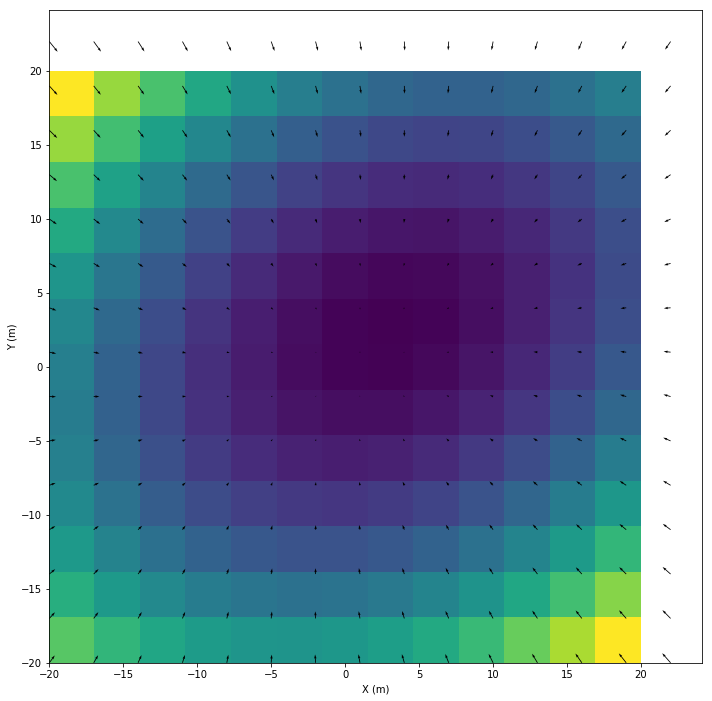

In [12]:
plt.figure(figsize=(12,12))
m = 20
c = 0
res = 3
tpo.plot_costmap_2(plt, model, data, goal, resolution=res, minimum=c-m, maximum=c+m)
ax = plt.gca()
tpo.policy_quiver(model, goal, ax, c, c, res, m, scale=25)
plt.xlabel("X (m)")
plt.ylabel("Y (m)");

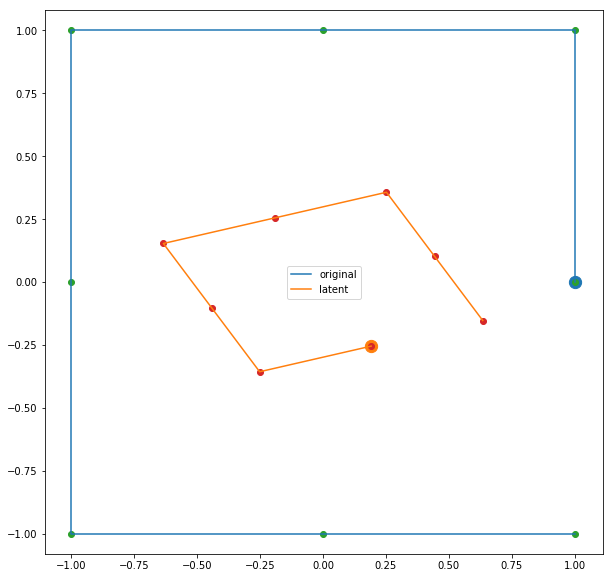

In [9]:
points = np.array([[1,0], [1,1], [0,1], [-1,1], [-1,0], [-1,-1], [0,-1], [1,-1]])
R = model.get_A()[:,:2]
new_points = []
for p in points:
    new_p = np.dot(R, p)
    new_points.append(new_p)
new_points = np.array(new_points)
    
plt.figure(figsize=(10,10))
plt.scatter([points[0,0]], [points[0,1]], s=150)
plt.scatter([new_points[0,0]], [new_points[0,1]], s=150)
plt.scatter([p[0] for p in points], [p[1] for p in points])
plt.scatter([p[0] for p in new_points], [p[1] for p in new_points])
plt.plot([p[0] for p in points], [p[1] for p in points], label='original')
plt.plot([p[0] for p in new_points], [p[1] for p in new_points], label='latent')
plt.legend()
plt.axis("equal");